In [3]:
import pandas as pd

# Load the CSVs
elections = pd.read_csv('view_election.csv')
parties = pd.read_csv('view_party.csv')


In [4]:
import pandas as pd


# Merge view_party (only party_family and family_id) into view_election
merged = elections.merge(
    parties[['id', 'party_family', 'family_id']],
    how='left',
    left_on='party_id',
    right_on='id'
)

# Drop the extra 'id' column from view_party (keep the original election 'id')
merged = merged.drop(columns='id_y').rename(columns={'id_x': 'id'})

# Save or preview
merged.to_csv('elections_with_party_family_and_family_id.csv', index=False)
print(merged.head())

  country        date        type     party    id                  created_at  \
0     AUS  1901-03-30  parliament        PP  6203  2024-08-15 07:30:26.238000   
1     AUS  1901-03-30  parliament       FTP  6256  2024-08-15 07:30:26.399000   
2     AUS  1901-03-30  parliament       ALP  6401  2024-08-15 07:30:26.877000   
3     AUS  1901-03-30  parliament      none  6224  2024-08-15 07:30:26.295000   
4     AUS  1901-03-30  parliament  one-seat  6335  2024-08-15 07:30:26.663000   

                   updated_at party_id_source  seats  vote_share     votes  \
0  2024-08-15 07:30:26.240000            PROT   32.0        44.4  189294.0   
1  2024-08-15 07:30:26.401000              FT   26.0        34.2  145611.0   
2  2024-08-15 07:30:26.879000             ALP   15.0        19.4   82734.0   
3  2024-08-15 07:30:26.297000          Others    1.0         1.4    5815.0   
4  2024-08-15 07:30:26.665000      Ind. Labor    1.0         0.6    2569.0   

  data_source                          descr

In [3]:
import pandas as pd

# Load your merged dataset
df = pd.read_csv('elections_with_party_family_and_family_id.csv')

# Convert to datetime and extract year
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Group by country, year, and party_family to get total seat share and vote share per ideology
ideology_trends = df.groupby(['country', 'year', 'party_family']).agg({
    'seats': 'sum',
    'vote_share': 'sum'
}).reset_index()


In [4]:
# Normalize within each (country, year)
ideology_trends['seat_pct'] = ideology_trends.groupby(['country', 'year'])['seats'].transform(lambda x: x / x.sum())
ideology_trends['vote_pct'] = ideology_trends.groupby(['country', 'year'])['vote_share'].transform(lambda x: x / x.sum())


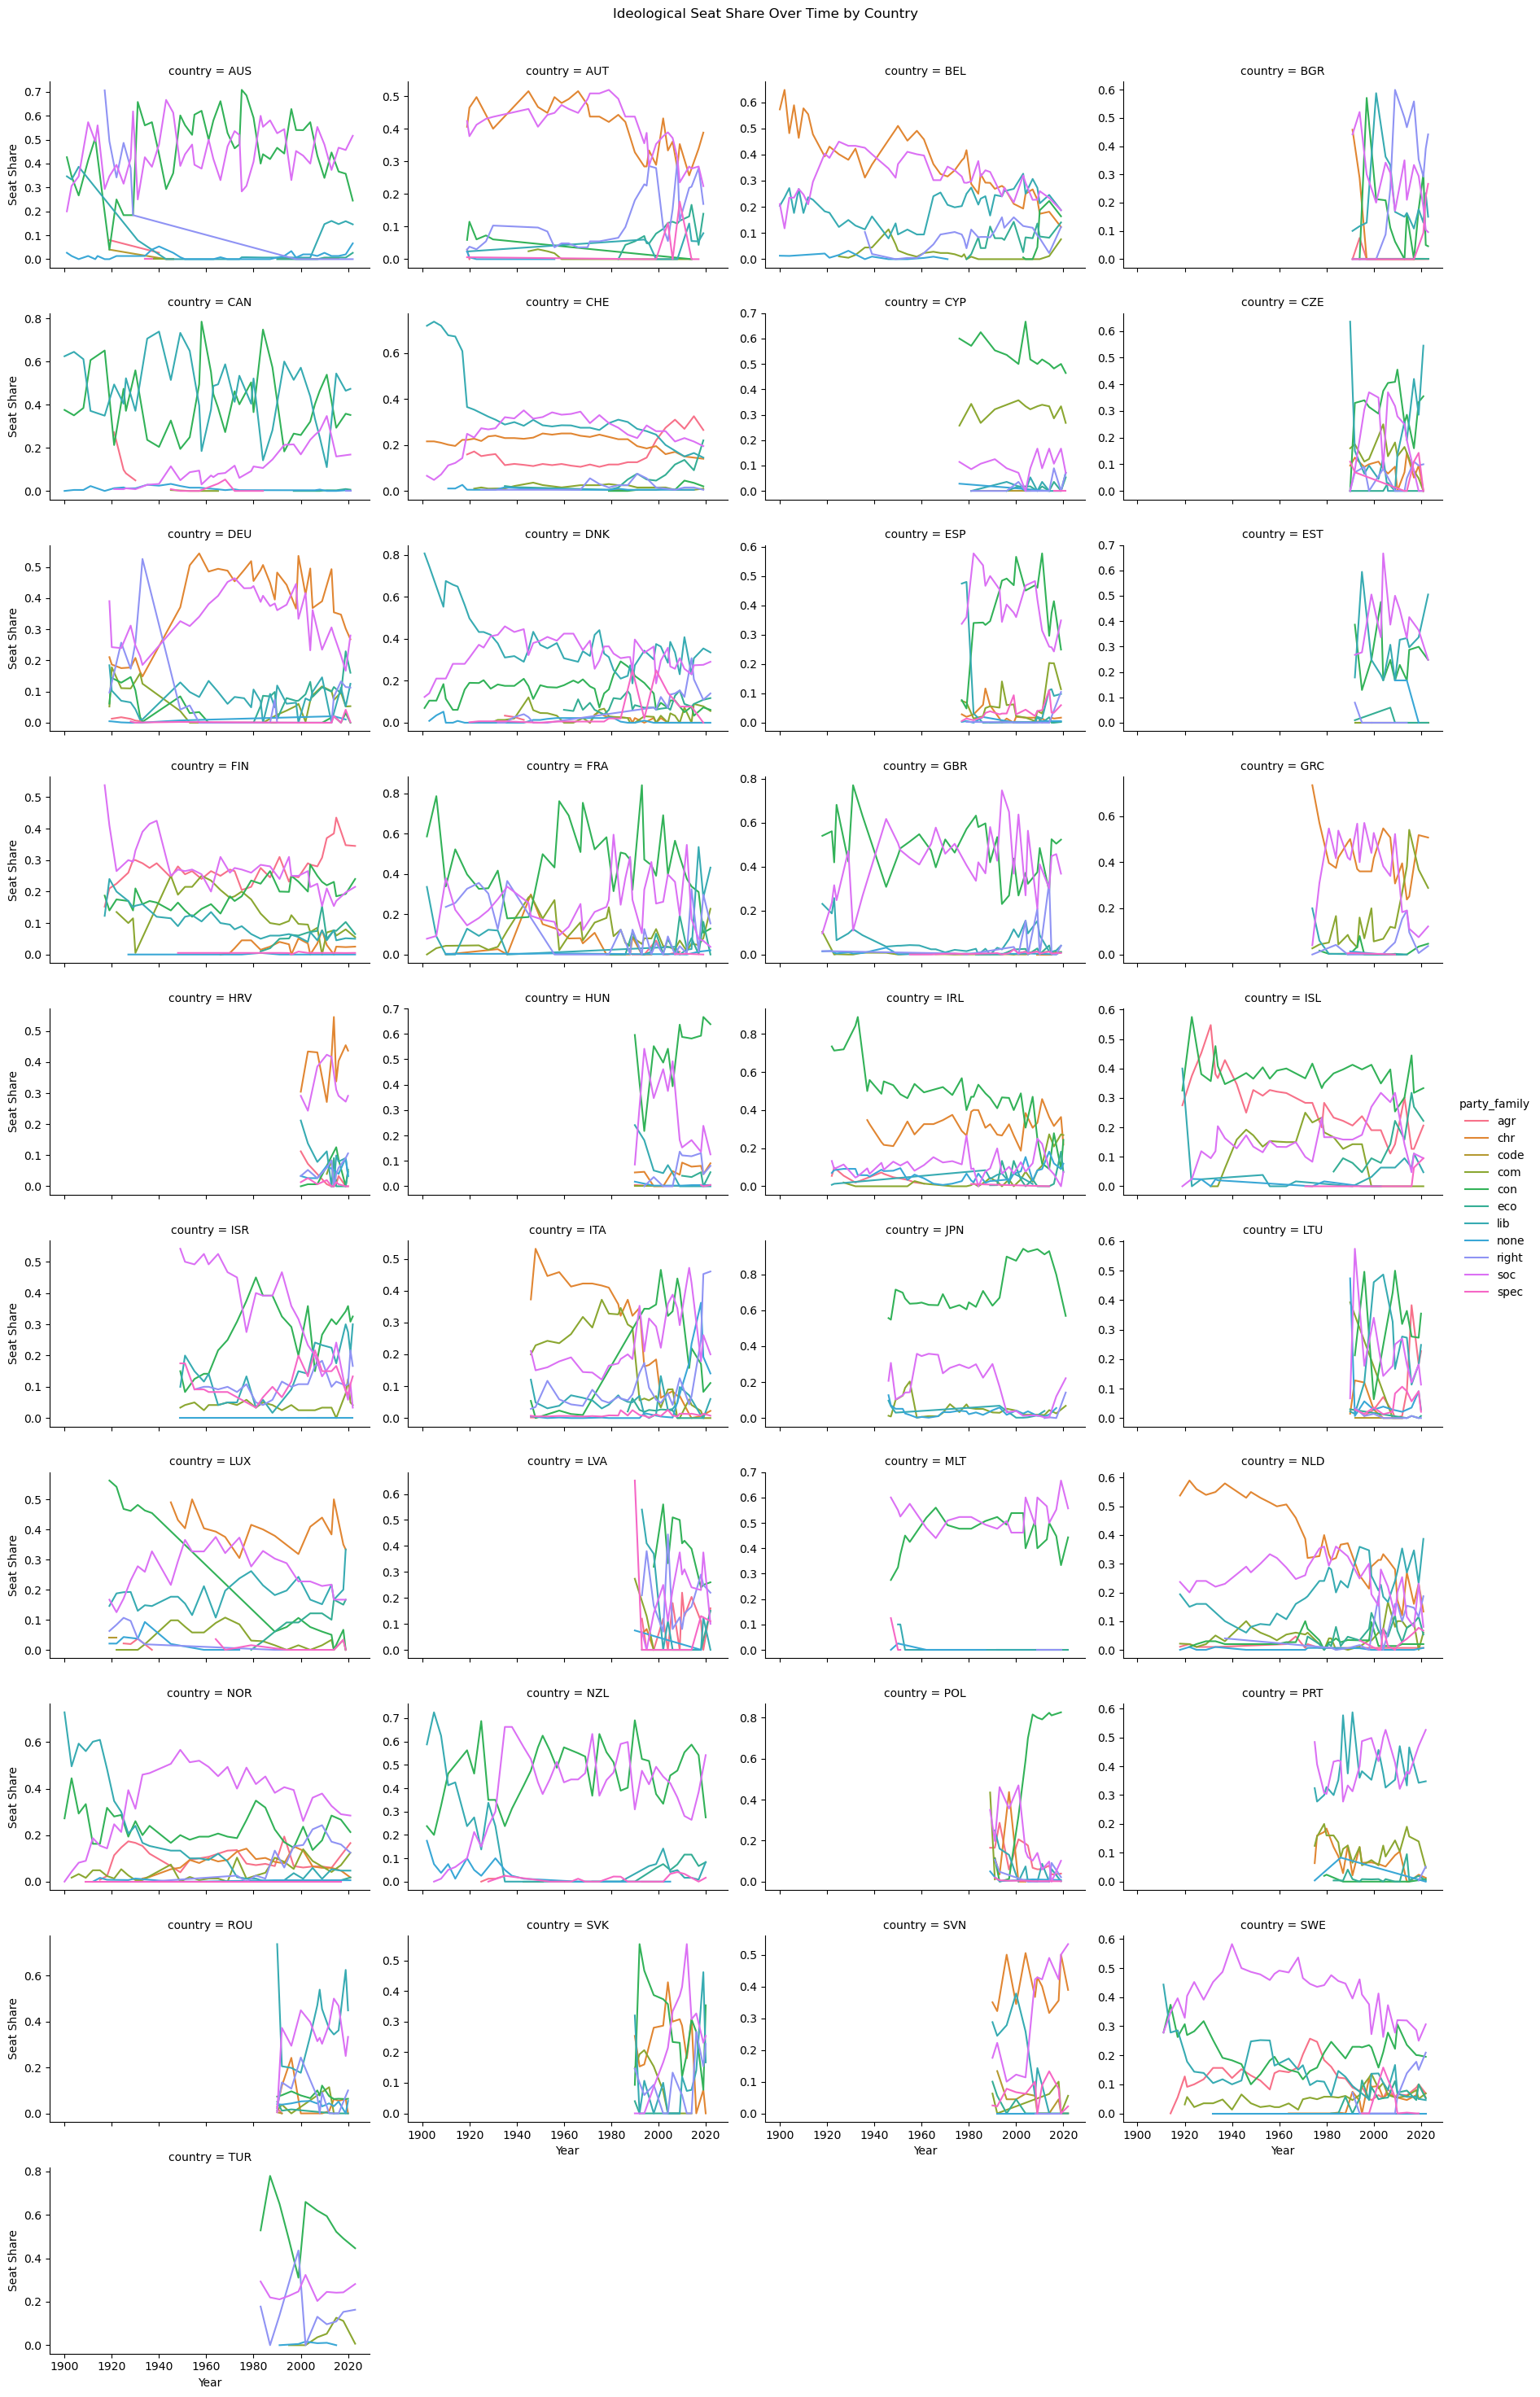

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'party_family' is treated as a category
ideology_trends['party_family'] = ideology_trends['party_family'].astype('category')

# Filter to countries with enough data (optional)
countries_with_enough_data = ideology_trends['country'].value_counts()
selected_countries = countries_with_enough_data[countries_with_enough_data > 5].index
subset = ideology_trends[ideology_trends['country'].isin(selected_countries)]

# Create the FacetGrid
g = sns.FacetGrid(
    subset,
    col='country',
    hue='party_family',
    col_wrap=4,
    height=3,
    aspect=1.5,
    sharey=False
)
g.map(plt.plot, 'year', 'seat_pct').add_legend()
g.set_axis_labels("Year", "Seat Share")
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Ideological Seat Share Over Time by Country")
plt.show()


<Figure size 1400x700 with 0 Axes>

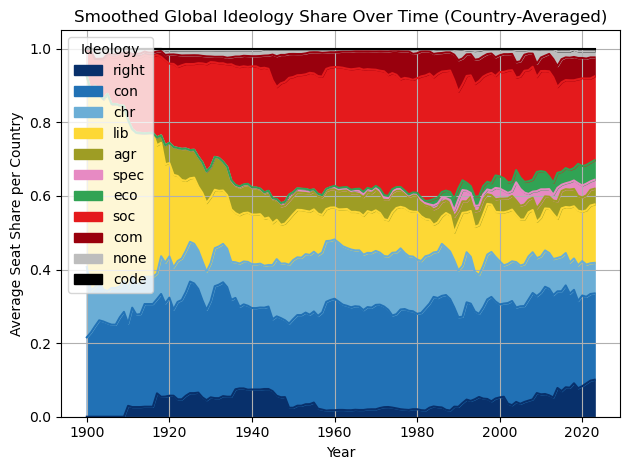

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Prepare merged data
merged['date'] = pd.to_datetime(merged['date'])
merged['year'] = merged['date'].dt.year

# Step 2: Build full panel of all country-year-party combinations
years = range(merged['year'].min(), merged['year'].max() + 1)
countries = merged['country'].unique()
party_families = merged['party_family'].dropna().unique()

panel = pd.MultiIndex.from_product(
    [countries, years, party_families],
    names=['country', 'year', 'party_family']
).to_frame(index=False)

# Step 3: Aggregate actual seat data
seat_data = merged.groupby(['country', 'year', 'party_family'], dropna=False)['seats'].sum().reset_index()

# Step 4: Merge and forward-fill missing values
df = panel.merge(seat_data, on=['country', 'year', 'party_family'], how='left')
df = df.sort_values(['country', 'party_family', 'year'])
df['seats'] = df.groupby(['country', 'party_family'])['seats'].ffill().fillna(0)

# Step 5: Normalize seat share within each country-year
df['total_seats'] = df.groupby(['country', 'year'])['seats'].transform('sum')
df['seat_share'] = df['seats'] / df['total_seats']

# Step 6: Average globally (each country contributes equally)
agg = df.groupby(['year', 'party_family'])['seat_share'].mean().reset_index()

# Step 7: Pivot to wide format for plotting
pivot = agg.pivot(index='year', columns='party_family', values='seat_share').fillna(0)

# Step 8: Reorder ideologies from right to left
ordered_ideologies = ['right', 'con', 'chr', 'lib', 'agr', 'spec', 'eco', 'soc', 'com', 'none', 'code']
existing = [i for i in ordered_ideologies if i in pivot.columns]
pivot = pivot[existing]

# Step 9: Define intuitive colors per ideology
colors = {
    'right': '#08306b',     # dark blue
    'con': '#2171b5',       # conservative blue
    'chr': '#6baed6',       # Christian democrat light blue
    'lib': '#fdd835',       # liberal yellow
    'agr': '#9e9d24',       # agrarian olive
    'spec': '#e78ac3',      # special interest pink
    'eco': '#31a354',       # green
    'soc': '#e41a1c',       # social democrat red
    'com': '#99000d',       # communist dark red
    'none': '#bdbdbd',      # gray
    'code': '#000000'       # black
}
color_list = [colors[i] for i in pivot.columns]

# Step 10: Plot stacked area chart
plt.figure(figsize=(14, 7))
pivot.plot.area(color=color_list)
plt.title("Smoothed Global Ideology Share Over Time (Country-Averaged)")
plt.xlabel("Year")
plt.ylabel("Average Seat Share per Country")
plt.legend(title='Ideology', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



<Figure size 1400x700 with 0 Axes>

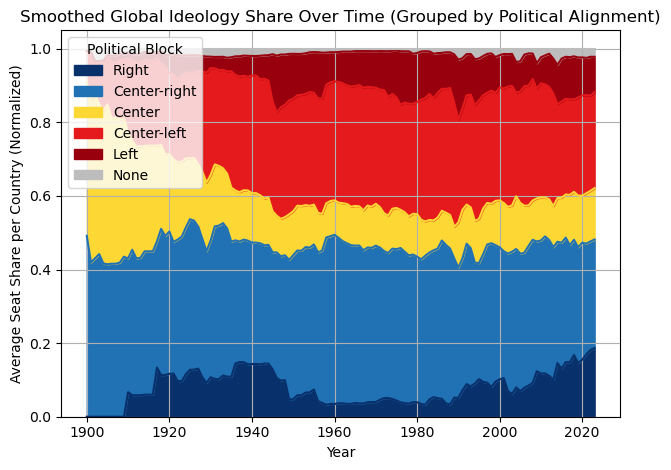

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Prepare merged data
merged['date'] = pd.to_datetime(merged['date'])
merged['year'] = merged['date'].dt.year

# Step 2: Build full panel of country-year-party_family
years = range(merged['year'].min(), merged['year'].max() + 1)
countries = merged['country'].unique()
party_families = merged['party_family'].dropna().unique()

panel = pd.MultiIndex.from_product(
    [countries, years, party_families],
    names=['country', 'year', 'party_family']
).to_frame(index=False)

# Step 3: Aggregate actual seat data
seat_data = merged.groupby(['country', 'year', 'party_family'], dropna=False)['seats'].sum().reset_index()

# Step 4: Merge and forward-fill missing values
df = panel.merge(seat_data, on=['country', 'year', 'party_family'], how='left')
df = df.sort_values(['country', 'party_family', 'year'])
df['seats'] = df.groupby(['country', 'party_family'])['seats'].ffill().fillna(0)

# Step 5: Normalize seat share within each country-year
df['total_seats'] = df.groupby(['country', 'year'])['seats'].transform('sum')
df['seat_share'] = df['seats'] / df['total_seats']

# Step 5.5: Map party families into broader ideological blocks
ideology_groups = {
    'right': 'Right',
    'con': 'Center-right',
    'chr': 'Center-right',
    'lib': 'Center',
    'agr': 'Center',
    'spec': 'Center',
    'eco': 'Center-left',
    'soc': 'Center-left',
    'com': 'Left',
    'none': 'None',
    'code': 'None'
}
df['ideology_group'] = df['party_family'].map(ideology_groups)
df = df[df['ideology_group'].notna()]  # Drop rows not assigned to a group

# Step 6: Group by year and ideology group (country-averaged)
agg = df.groupby(['year', 'ideology_group'])['seat_share'].mean().reset_index()

# Step 7: Pivot for plotting
pivot = agg.pivot(index='year', columns='ideology_group', values='seat_share').fillna(0)

# Step 8: Reorder and normalize so each year's total sums to 1 (100%)
group_order = ['Right', 'Center-right', 'Center', 'Center-left', 'Left', 'None']
pivot = pivot[[g for g in group_order if g in pivot.columns]]
pivot = pivot.div(pivot.sum(axis=1), axis=0)  # Normalize each row to sum to 1

# Step 9: Define color scheme
group_colors = {
    'Right': '#08306b',         # dark blue
    'Center-right': '#2171b5',  # blue
    'Center': '#fdd835',        # yellow
    'Center-left': '#e41a1c',   # red
    'Left': '#99000d',          # dark red
    'None': '#bdbdbd'           # gray
}
color_list = [group_colors[g] for g in pivot.columns]

# Step 10: Plot
plt.figure(figsize=(14, 7))
pivot.plot.area(color=color_list)
plt.title("Smoothed Global Ideology Share Over Time (Grouped by Political Alignment)")
plt.xlabel("Year")
plt.ylabel("Average Seat Share per Country (Normalized)")
plt.legend(title='Political Block', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import plotly.express as px

# 1. Assume `merged` already contains party_family
df = merged.copy()
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['decade'] = (df['year'] // 10) * 10

# 2. Map ideologies to orientation
ideology_map = {
    'com': 'left', 'soc': 'left', 'eco': 'left',
    'lib': 'center', 'chr': 'center', 'agr': 'center', 'spec': 'center',
    'con': 'right', 'right': 'right',
    'none': 'none', 'code': 'none'
}
df['orientation'] = df['party_family'].map(ideology_map)

# 3. Aggregate seats per country/decade/orientation
agg = df.groupby(['country', 'decade', 'orientation'], dropna=False)['seats'].sum().reset_index()

# 4. Get dominant orientation per country/decade
dominant = agg.sort_values(['country', 'decade', 'seats'], ascending=False)\
              .drop_duplicates(['country', 'decade'])

# 5. Loop through decades and plot with Plotly
for decade in sorted(dominant['decade'].unique()):
    ddf = dominant[dominant['decade'] == decade]

    fig = px.choropleth(
        ddf,
        locations="country",         # ISO 3-letter codes (AUS, DEU, etc.)
        color="orientation",         # left, center, right, none
        color_discrete_map={
            "left": "red",
            "center": "gold",
            "right": "blue",
            "none": "lightgray"
        },
        title=f"Dominant Political Orientation by Country — {decade}s",
        locationmode="ISO-3",
        projection="natural earth"
    )
    fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
    fig.show()


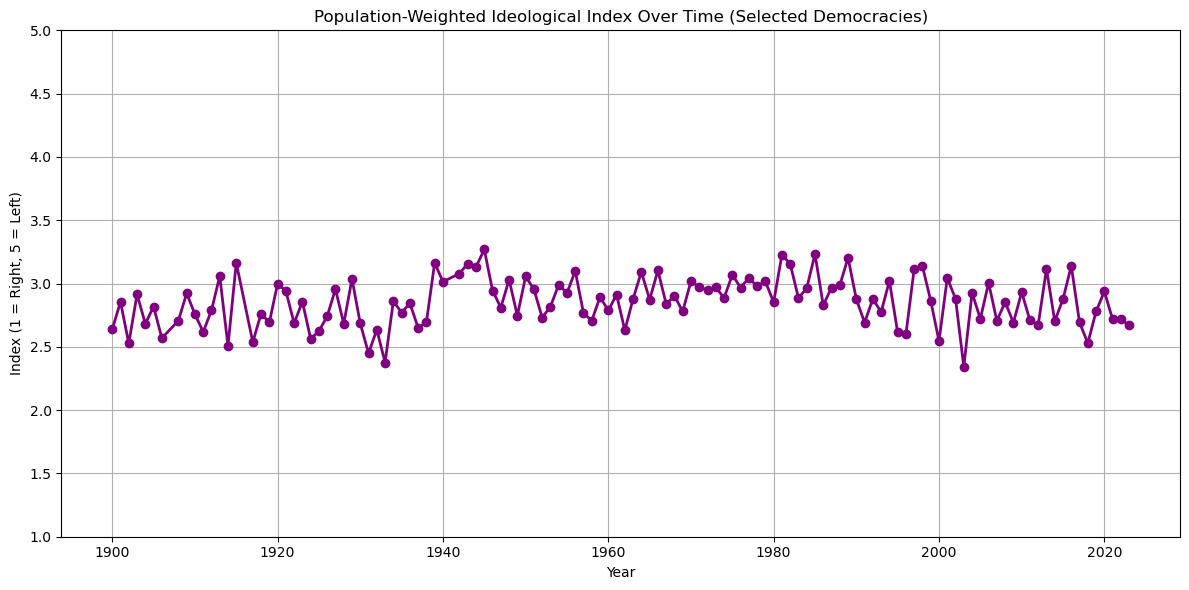

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# STEP 1: Load and prepare population data
population_df = pd.read_csv("population.csv")
population_df.columns = population_df.columns.str.strip()
population_df = population_df.rename(columns={
    'Country Code': 'country',
    'Year': 'year',
    'Value': 'population'
})
population_df['year'] = population_df['year'].astype(int)
population_df['country'] = population_df['country'].str.upper()
population_df['population'] = population_df['population'] / 1_000_000

# Filter to selected countries only
selected_countries = [
    'AUS', 'AUT', 'BEL', 'BGR', 'CAN', 'CHE', 'CYP', 'CZE', 'DEU', 'DNK',
    'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ISL',
    'ISR', 'ITA', 'JPN', 'LTU', 'LUX', 'LVA', 'MLT', 'NLD', 'NOR', 'NZL',
    'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'SWE', 'TUR'
]
population_df = population_df[population_df['country'].isin(selected_countries)]

# STEP 2: Fill missing years with ffill/bfill
all_years = merged['date'].dt.year.unique()
all_combos = pd.MultiIndex.from_product(
    [selected_countries, all_years],
    names=['country', 'year']
).to_frame(index=False)

population_filled = all_combos.merge(population_df, on=['country', 'year'], how='left')
population_filled = population_filled.sort_values(['country', 'year'])
population_filled['population'] = population_filled.groupby('country')['population'].ffill().bfill()

# STEP 3: Map party_family to ideological blocks and scores
ideology_groups = {
    'right': 'Right',
    'con': 'Center-right',
    'chr': 'Center-right',
    'lib': 'Center',
    'agr': 'Center',
    'spec': 'Center',
    'eco': 'Center-left',
    'soc': 'Center-left',
    'com': 'Left',
    'none': None,
    'code': None
}
ideology_index = {
    'Right': 1,
    'Center-right': 2,
    'Center': 3,
    'Center-left': 4,
    'Left': 5
}

# STEP 4: Prepare election data
merged['date'] = pd.to_datetime(merged['date'])
merged['year'] = merged['date'].dt.year.astype(int)
merged['country'] = merged['country'].str.upper()
merged = merged[merged['country'].isin(selected_countries)]
merged['ideology_group'] = merged['party_family'].map(ideology_groups)
merged = merged[merged['ideology_group'].notna()]

# STEP 5: Compute country-year ideology score
seats = merged.groupby(['country', 'year', 'ideology_group'])['seats'].sum().reset_index()
seats['total_seats'] = seats.groupby(['country', 'year'])['seats'].transform('sum')
seats['seat_share'] = seats['seats'] / seats['total_seats']
seats['ideology_score'] = seats['ideology_group'].map(ideology_index)
seats['score_contrib'] = seats['seat_share'] * seats['ideology_score']

# Now collapse to country-year ideology score
country_scores = seats.groupby(['country', 'year'])['score_contrib'].sum().reset_index()
country_scores = country_scores.rename(columns={'score_contrib': 'country_ideology_score'})

# STEP 6: Merge population for weighting
df = country_scores.merge(population_filled, on=['country', 'year'], how='left')
df = df[df['population'].notna()]

# STEP 7: Compute population-weighted average per year
df['pop_weighted'] = df['country_ideology_score'] * df['population']
result = df.groupby('year').agg({
    'pop_weighted': 'sum',
    'population': 'sum'
}).reset_index()
result['population_weighted_index'] = result['pop_weighted'] / result['population']

# STEP 8: Plot
plt.figure(figsize=(12, 6))
plt.plot(result['year'], result['population_weighted_index'], marker='o', linewidth=2, color='purple')
plt.title("Population-Weighted Ideological Index Over Time (Selected Democracies)")
plt.xlabel("Year")
plt.ylabel("Index (1 = Right, 5 = Left)")
plt.ylim(1, 5)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/7_/ghx1162d0537kl1f7dbrlb0c0000gn/T/ipykernel_94590/2983269370.py:88: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



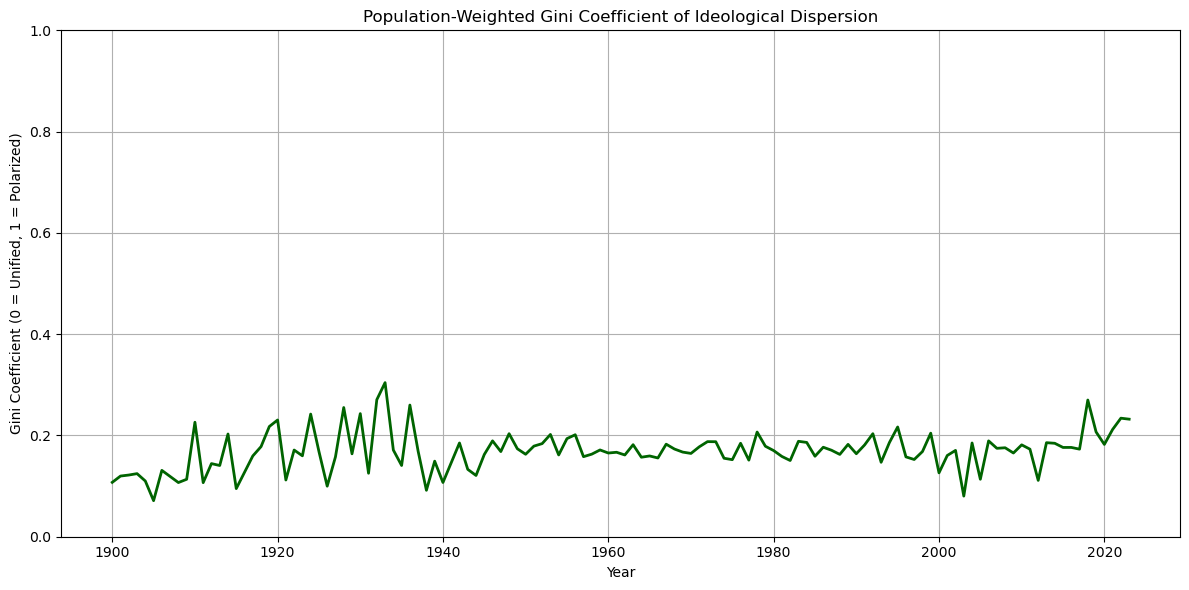

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Load and clean population data
population_df = pd.read_csv("population.csv")
population_df.columns = population_df.columns.str.strip()
population_df = population_df.rename(columns={
    'Country Code': 'country',
    'Year': 'year',
    'Value': 'population'
})
population_df['year'] = population_df['year'].astype(int)
population_df['country'] = population_df['country'].str.upper()
population_df['population'] = population_df['population'] / 1_000_000  # in millions

# STEP 2: Filter to selected countries and fill missing years
selected_countries = [
    'AUS', 'AUT', 'BEL', 'BGR', 'CAN', 'CHE', 'CYP', 'CZE', 'DEU', 'DNK',
    'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HRV', 'HUN', 'IRL', 'ISL',
    'ISR', 'ITA', 'JPN', 'LTU', 'LUX', 'LVA', 'MLT', 'NLD', 'NOR', 'NZL',
    'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'SWE', 'TUR'
]
population_df = population_df[population_df['country'].isin(selected_countries)]

# Fill missing years
all_years = merged['date'].dt.year.unique()
all_combos = pd.MultiIndex.from_product(
    [selected_countries, all_years],
    names=['country', 'year']
).to_frame(index=False)
population_filled = all_combos.merge(population_df, on=['country', 'year'], how='left')
population_filled = population_filled.sort_values(['country', 'year'])
population_filled['population'] = population_filled.groupby('country')['population'].ffill().bfill()

# STEP 3: Ideology mapping
ideology_groups = {
    'right': 'Right',
    'con': 'Center-right',
    'chr': 'Center-right',
    'lib': 'Center',
    'agr': 'Center',
    'spec': 'Center',
    'eco': 'Center-left',
    'soc': 'Center-left',
    'com': 'Left',
    'none': None,
    'code': None
}
ideology_index = {
    'Right': 1,
    'Center-right': 2,
    'Center': 3,
    'Center-left': 4,
    'Left': 5
}

# STEP 4: Prepare election data
merged['date'] = pd.to_datetime(merged['date'])
merged['year'] = merged['date'].dt.year.astype(int)
merged['country'] = merged['country'].str.upper()
merged = merged[merged['country'].isin(selected_countries)]
merged['ideology_group'] = merged['party_family'].map(ideology_groups)
merged = merged[merged['ideology_group'].notna()]

# STEP 5: Aggregate seats and compute seat shares
seats = merged.groupby(['country', 'year', 'ideology_group'])['seats'].sum().reset_index()
seats['total_seats'] = seats.groupby(['country', 'year'])['seats'].transform('sum')
seats['seat_share'] = seats['seats'] / seats['total_seats']
seats['ideology_score'] = seats['ideology_group'].map(ideology_index)

# STEP 6: Correct weighted Gini function
def weighted_gini(x, w):
    """Compute Gini coefficient for weighted data"""
    sorted_idx = np.argsort(x)
    x = np.asarray(x)[sorted_idx]
    w = np.asarray(w)[sorted_idx]

    cumw = np.cumsum(w)
    cumxw = np.cumsum(x * w)
    total_w = cumw[-1]
    total_xw = cumxw[-1]

    gini = 1 - 2 * np.sum((cumxw - (x * w) / 2) * w) / (total_xw * total_w)
    return gini

# STEP 7: Compute per-country-year Gini
country_scores = seats.groupby(['country', 'year']).apply(
    lambda g: pd.Series({
        'country_gini': weighted_gini(g['ideology_score'], g['seat_share'])
    })
).reset_index()

# STEP 8: Merge population and compute population-weighted Gini
df = country_scores.merge(population_filled, on=['country', 'year'], how='left')
df = df[df['population'].notna()]
df['weighted_gini'] = df['country_gini'] * df['population']

# STEP 9: Aggregate to get population-weighted Gini per year
gini_result = df.groupby('year').agg({
    'weighted_gini': 'sum',
    'population': 'sum'
}).reset_index()
gini_result['avg_gini'] = gini_result['weighted_gini'] / gini_result['population']

# STEP 10: Plot
plt.figure(figsize=(12, 6))
plt.plot(gini_result['year'], gini_result['avg_gini'], color='darkgreen', linewidth=2)
plt.title("Population-Weighted Gini Coefficient of Ideological Dispersion")
plt.xlabel("Year")
plt.ylabel("Gini Coefficient (0 = Unified, 1 = Polarized)")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()



In [20]:
import plotly.io as pio
pio.renderers.default = "browser"


In [21]:
fig.show()


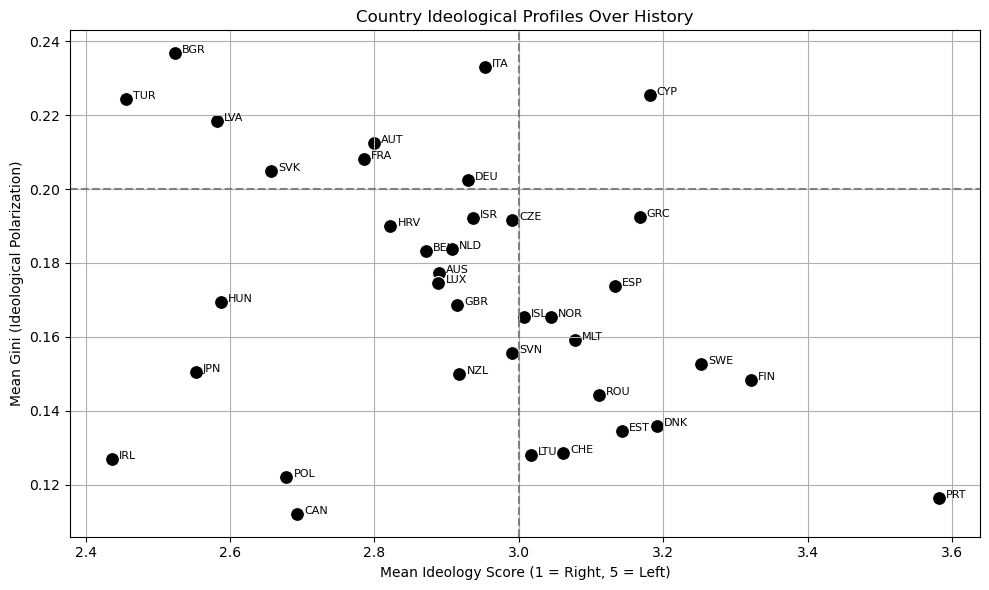

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `country_profiles` is already defined with:
# - 'mean_ideology' (1 = Right, 5 = Left)
# - 'mean_gini' (ideological polarization)
# - 'country' (ISO code)

plt.figure(figsize=(10, 6))

# Plain black dots
sns.scatterplot(
    data=country_profiles,
    x='mean_ideology',
    y='mean_gini',
    color='black',
    s=100
)

# Add country labels
for _, row in country_profiles.iterrows():
    plt.text(row['mean_ideology'] + 0.01, row['mean_gini'], row['country'], fontsize=8)

# Optional reference lines
plt.axhline(0.2, linestyle='--', color='gray')
plt.axvline(3, linestyle='--', color='gray')

plt.title("Country Ideological Profiles Over History")
plt.xlabel("Mean Ideology Score (1 = Right, 5 = Left)")
plt.ylabel("Mean Gini (Ideological Polarization)")
plt.grid(True)
plt.tight_layout()
plt.show()




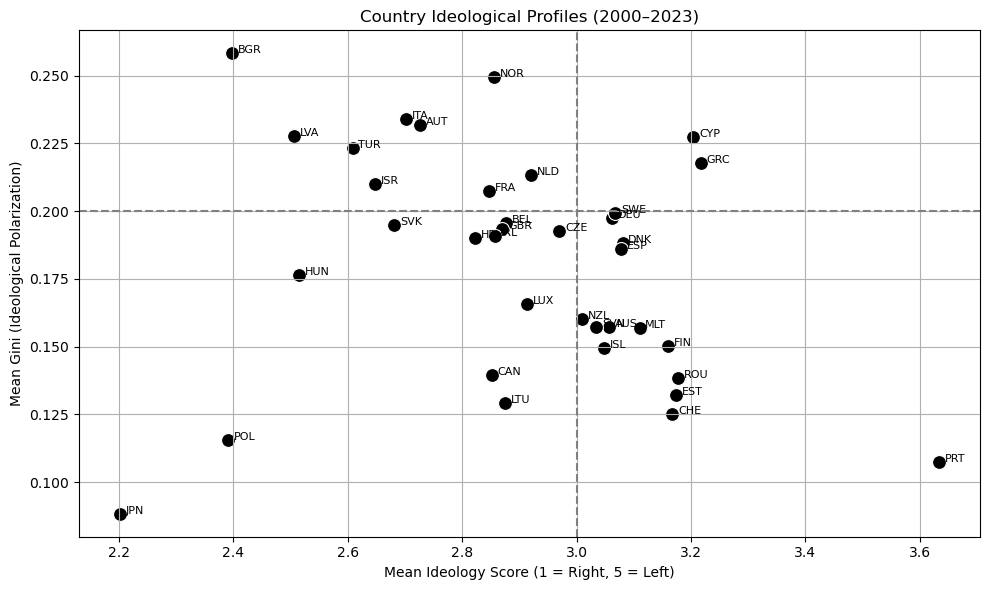

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Filter country_scores to 2000 and later
recent_scores = country_scores[country_scores['year'] >= 2000]

# Step 2: Recompute average ideology and Gini by country (2000–2023)
country_profiles_recent = recent_scores.groupby('country').agg({
    'country_ideology_score': 'mean',
    'country_gini': 'mean'
}).reset_index().rename(columns={
    'country_ideology_score': 'mean_ideology',
    'country_gini': 'mean_gini'
})

# Step 3: Plot
plt.figure(figsize=(10, 6))

# Plain black scatter plot
sns.scatterplot(
    data=country_profiles_recent,
    x='mean_ideology',
    y='mean_gini',
    color='black',
    s=100
)

# Add country ISO labels
for _, row in country_profiles_recent.iterrows():
    plt.text(row['mean_ideology'] + 0.01, row['mean_gini'], row['country'], fontsize=8)

# Optional reference lines
plt.axhline(0.2, linestyle='--', color='gray')
plt.axvline(3, linestyle='--', color='gray')

plt.title("Country Ideological Profiles (2000–2023)")
plt.xlabel("Mean Ideology Score (1 = Right, 5 = Left)")
plt.ylabel("Mean Gini (Ideological Polarization)")
plt.grid(True)
plt.tight_layout()
plt.show()


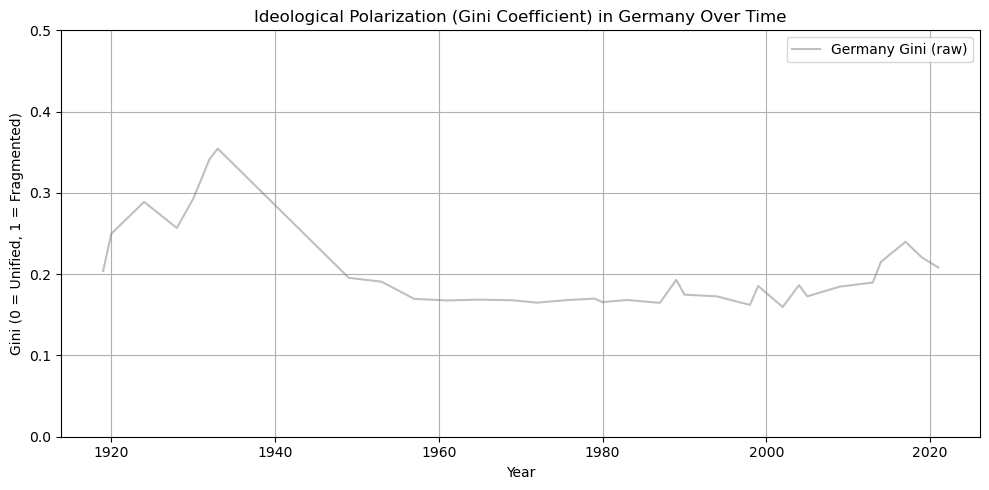

In [54]:
import matplotlib.pyplot as plt

# Filter for Germany (DEU)
germany_scores = country_scores[country_scores['country'] == 'DEU'].copy()


# Plot
plt.figure(figsize=(10, 5))
plt.plot(germany_scores['year'], germany_scores['country_gini'], label='Germany Gini (raw)', color='gray', alpha=0.5)

plt.title("Ideological Polarization (Gini Coefficient) in Germany Over Time")
plt.xlabel("Year")
plt.ylabel("Gini (0 = Unified, 1 = Fragmented)")
plt.ylim(0, 0.5)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [53]:
# Filter for Germany (DEU) in the 1930s and 1940s
germany_30s_40s = merged[
    (merged['country'] == 'DEU') &
    (merged['year'] >= 1930) &
    (merged['year'] <= 1949)
].copy()

# Optional: keep only key columns for clarity
germany_30s_40s = germany_30s_40s[[
    'year', 'party', 'party_family', 'ideology_group',
    'seats', 'vote_share', 'election_id'
]].sort_values(by=['year', 'seats'], ascending=[True, False])

# Display grouped by year
for year in sorted(germany_30s_40s['year'].unique()):
    print(f"\n🗳️ German Election Year: {year}")
    display(germany_30s_40s[germany_30s_40s['year'] == year])



🗳️ German Election Year: 1930


,year,party,party_family,ideology_group,seats,vote_share,election_id
2207,1930,SPD,soc,Center-left,143.0,24.53,1037
2208,1930,NSDAP,right,Right,107.0,18.25,1037
2209,1930,KPD,com,Left,77.0,13.13,1037
2210,1930,DZ,chr,Center-right,68.0,11.63,1037
2211,1930,DNVP,right,Right,41.0,7.03,1037
2212,1930,DVP,con,Center-right,30.0,4.86,1037
2213,1930,WP,con,Center-right,23.0,3.90,1037
2214,1930,DDP,lib,Center,20.0,3.44,1037
2215,1930,BVP,chr,Center-right,19.0,3.20,1037
2216,1930,CNBL,chr,Center-right,19.0,2.82,1037



🗳️ German Election Year: 1932


,year,party,party_family,ideology_group,seats,vote_share,election_id
2224,1932,NSDAP,right,Right,230.0,37.27,1038
2239,1932,NSDAP,right,Right,196.0,33.09,1039
2225,1932,SPD,soc,Center-left,133.0,21.58,1038
2240,1932,SPD,soc,Center-left,121.0,20.43,1039
2241,1932,KPD,com,Left,100.0,16.86,1039
2226,1932,KPD,com,Left,89.0,14.32,1038
2227,1932,DZ,chr,Center-right,75.0,12.28,1038
2242,1932,DZ,chr,Center-right,70.0,11.76,1039
2243,1932,DNVP,right,Right,51.0,8.34,1039
2228,1932,DNVP,right,Right,37.0,5.90,1038



🗳️ German Election Year: 1933


,year,party,party_family,ideology_group,seats,vote_share,election_id
2254,1933,NSDAP,right,Right,288.0,43.91,1040
2255,1933,SPD,soc,Center-left,120.0,18.25,1040
2256,1933,KPD,com,Left,81.0,12.32,1040
2257,1933,DZ,chr,Center-right,73.0,11.09,1040
2258,1933,DNVP,right,Right,52.0,7.97,1040
2259,1933,BVP,chr,Center-right,19.0,2.88,1040
2260,1933,DDP,lib,Center,5.0,0.85,1040
2261,1933,CSVD,chr,Center-right,4.0,0.98,1040
2262,1933,DVP,con,Center-right,2.0,1.10,1040
2263,1933,BBB,lib,Center,2.0,0.26,1040



🗳️ German Election Year: 1949


,year,party,party_family,ideology_group,seats,vote_share,election_id
2266,1949,SPD,soc,Center-left,131.0,29.2,581
2267,1949,CDU,chr,Center-right,115.0,25.2,581
2268,1949,FDP,lib,Center,52.0,11.9,581
2269,1949,CSU,chr,Center-right,24.0,5.8,581
2270,1949,BP,con,Center-right,17.0,4.2,581
2271,1949,DP,con,Center-right,17.0,4.0,581
2272,1949,KPD,com,Left,15.0,5.7,581
2273,1949,WAV,right,Right,12.0,2.9,581
2274,1949,DZ,chr,Center-right,10.0,3.1,581
2275,1949,DRP,right,Right,5.0,1.8,581
